In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.python.client import timeline
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


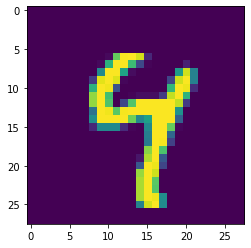

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)
X_tr=np.reshape(mnist.train.images,[-1,28,28])
Y_tr=mnist.train.labels
X_te=np.reshape(mnist.test.images,[-1,28,28])
Y_te=mnist.test.labels
X_val=np.reshape(mnist.validation.images,[-1,28,28])
Y_val=mnist.validation.labels
plt.imshow(X_tr[2,:,:])

## Preparing the data for Catastrophic forgetting simulation
The following function defines a list of indexes, where each group of indexes in the list refers to the indexes of the dataset
that belongs to a 'task'. The tasks are the set of data that will be played sequentially in the catastrophic forgetting 
simulation, where the network is trained over the data of a task only once.
In this case, the digits belonging to the first 5 classes compose the first task, while the remaining data compose 5 tasks, one for each digit. 


In [3]:
# Data for catastrophic


def Data_Catastrophic(Y_tr,Y_te,Y_val):

    Y_tr_class=np.argwhere(Y_tr==1)
    Y_te_class=np.argwhere(Y_te==1)
    Y_val_class=np.argwhere(Y_val==1)

    N_calss=np.shape(Y_tr,1)
    
    digits_perm=np.random.permutation(N_class)

    tr1=[]
    te1=[]

    tr2=[]
    te2=[]

    val1=[]
    val2=[]

    for i in range(N_class):

        if i<np.int(N_class/2):

            indexes=np.squeeze(np.argwhere(Y_tr_class[:,1]==digits_perm[i]))

            tr1=np.concatenate([tr1,np.int32(indexes)],axis=0)

            indexes=np.squeeze(np.argwhere(Y_te_class[:,1]==digits_perm[i]))

            te1=np.concatenate([te1,np.int32(indexes)],axis=0)

            indexes=np.squeeze(np.argwhere(Y_val_class[:,1]==digits_perm[i]))

            val1=np.concatenate([val1,np.int32(indexes)],axis=0)


        if i>=np.int(N_class/2):

            indexes=np.squeeze(np.argwhere(Y_tr_class[:,1]==digits_perm[i]))

            tr2.append(np.int32(indexes))

            indexes=np.squeeze(np.argwhere(Y_te_class[:,1]==digits_perm[i]))

            te2.append(np.int32(indexes))

            indexes=np.squeeze(np.argwhere(Y_val_class[:,1]==digits_perm[i]))

            val2.append(np.int32(indexes))



    tr1=np.int32(tr1)
    te1=np.int32(te1)
    val1=np.int32(val1)

    tr=[]
    te=[]
    val=[]

    tr.append(tr1)
    te.append(te1)
    val.append(val1)

    for i in range(np.int(N_class/2)):

        tr.append(tr2[i])
        te.append(te2[i])
        val.append(val2[i])
        
        N_tr_check=0
        N_te_check=0
        N_te=np.zeros(6)
        N_val=np.zeros(6)

    for i in range(np.int(N_class/2)+1):

        N_te[i]=np.shape(te[i])[0]
        N_val[i]=np.shape(val[i])[0]

        N_tr_check+=np.shape(tr[i])[0]
        N_te_check+=np.shape(te[i])[0]

    return tr, te, val, N_te, N_val
    
tr, te, val, N_te, N_val=Data_Catastrophic(Y_tr,Y_te,Y_val)   


# Check

N_tr_check=0
N_te_check=0
N_te=np.zeros(6)
N_val=np.zeros(6)

for i in range(6):
    
    N_te[i]=np.shape(te[i])[0]
    N_val[i]=np.shape(val[i])[0]
    
    N_tr_check+=np.shape(tr[i])[0]
    N_te_check+=np.shape(te[i])[0]
    
print(N_tr_check)
print(N_te_check)


55000
10000


## ESN, definition of the graph for the computation of the activities

In [4]:
class Echo:
    
    def __init__(self,dt,tau_m,tau_M,diluition,N,W_in):
            
            self.dt=dt
            self.N=N
            self.tau_m=tau_m
            self.tau_M=tau_M
            self.Diluition=diluition
            
            W_np=np.random.uniform(-1,1,[N,N])
            D=np.random.uniform(0,1,(N,N))>np.ones((N,N))*diluition
            W_np=W_np*D.astype(int)
            
            eig=np.linalg.eigvals(W_np)
            self.eig=eig
            
            alpha_np=dt/(2*tau_m)
            pho_np=1-2*tau_m/tau_M
            
            W_np=pho_np*W_np/(np.max(np.absolute(eig)))
            
            self.W_np=W_np
            self.alpha_np=alpha_np
            self.pho_np=pho_np
            
            self.W=tf.Variable(W_np,trainable=False,dtype=tf.float32)
            self.alpha=tf.constant(alpha_np,dtype=tf.float32)
            
            self.W_in_np=W_in
            self.W_in=tf.Variable(W_in,trainable=False,dtype=tf.float32)
            self.N_in=np.shape(W_in)[0]
            
            
    def evolution_graph(self,T,init_state,inputs):

        
        state_hidden=init_state
        states_hidden=[]
        xs=[]
        
        
        for t in range(T):
            
            prev_state=tf.identity(state_hidden)
            state_hidden=( (1-self.alpha)*prev_state+self.alpha*tf.tanh( tf.matmul(prev_state,self.W)+tf.matmul(inputs[:,:,t],self.W_in) ))
            states_hidden.append(state_hidden)
            
        states=tf.concat([tf.expand_dims(s,2) for s in states_hidden],2)

    
        return states, state_hidden


In [5]:
def W_input(N_proj,N,n_mean_conn):

    W_In=np.random.randn(N,N_proj)

    return W_In

## Definition of the specificty metric 


In [6]:
def specificity(state,labels,N_e,in_task):
    
    if in_task==True:
    
        N_class=np.shape(labels)[1]
        N=np.shape(state)[1]

        activation_class=np.zeros([N,N_class])
        
        for i in range(N_class):

            activity_class=state*np.tile(np.expand_dims(labels[:,i],1),[1,N])

            activation_class[:,i]=np.transpose(np.sum((activity_class>0),0))        

    else:
        
        N_class=np.shape(state)[0]
        N=np.shape(state[0])[1]
        
        activation_class=np.zeros([N,N_class])

        for i in range(N_class):

            activation_class[:,i]=np.transpose(np.sum((state[i]>0),0))        
        
        
    spec_tensor=np.zeros([N,N_class,N_class])
    spec_tensor1=np.zeros([N,N_class,N_class])

    spec=np.zeros([N])
    spec1=np.zeros([N])
    
    
    spec_new=np.zeros([N])
    spec1_new=np.zeros([N])
    
    overlap=np.zeros([N,N_class])
    overlap1=np.zeros([N,N_class])
    
    C_active=np.sum(activation_class>0,1)
    
    index_=np.sum(activation_class,1)>0
    
    for i in range(N_class):
        
        overlap[:,i]=activation_class[:,i]/N_e[i]
        
        overlap1[index_,i]=(activation_class[index_,i]/N_e[i])/np.max(activation_class[index_,:]/np.tile(N_e,[int(np.sum(index_)),1]),1)
        
        
        for j in range(N_class):
            
            activation_den=activation_class[:,i]+activation_class[:,j]>0
                        
            spec_tensor1[:,i,j]=np.absolute(activation_class[:,i]/N_e[i]-activation_class[:,j]/N_e[j])
            
            spec_tensor[activation_den,i,j]=spec_tensor1[activation_den,i,j]/(activation_class[activation_den,i]/N_e[i]+activation_class[activation_den,j]/N_e[j])
            
    for i in range(N):
        
        if np.sum(spec_tensor[i,:,:]>0)>0:
            
            spec[i]=np.mean(spec_tensor[i,spec_tensor[i,:,:]>0])
            spec1[i]=np.mean(spec_tensor1[i,spec_tensor[i,:,:]>0])
            
            
    return spec, spec1, overlap, overlap1, C_active

## ESN representation over the dataset

The data are splitted because of the limited memory in my gpu

In [18]:
def Compute_states(N,dt,T,tau_m,tau_M,diluition,N_proj):
    
    W_in=np.random.randn(N,N_proj)
    W_in=0.1*W_in.T

    rnn=Echo(dt,tau_m,tau_M,diluition,N,W_in)

    init_state=tf.placeholder(tf.float32,[None,N])
    s=tf.placeholder(tf.float32,[None,N_proj,T])

    states,state=rnn.evolution_graph(T,init_state,s)

    init=tf.global_variables_initializer()

    train_divide=20
    N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

    Data_train=np.zeros([np.shape(Y_tr)[0],N,T])

    test_divide=10
    N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))

    Data_test=np.zeros([np.shape(Y_te)[0],N,T])
    
    val_divide=10
    N_val_d=int(np.floor(np.shape(Y_val)[0]/val_divide))

    Data_val=np.zeros([np.shape(Y_val)[0],N,T])


    with tf.Session() as sess:

        sess.run(init)

        print('Computing States for the training set')

        for l in range(train_divide):

            images=X_tr[l*N_train_d:(l+1)*N_train_d,:,:]
            labels=Y_tr[l*N_train_d:(l+1)*N_train_d,:]

            states_=sess.run(states,feed_dict={init_state:np.zeros([N_train_d,N]),s:images})

            Data_train[l*N_train_d:(l+1)*N_train_d,:,:]=states_

        print('Computing States for the test set')

        for l in range(test_divide):

            images=X_te[l*N_test_d:(l+1)*N_test_d,:,:]
            labels=Y_te[l*N_test_d:(l+1)*N_test_d,:]

            states_=sess.run(states,feed_dict={init_state:np.zeros([N_test_d,N]),s:images})

            Data_test[l*N_test_d:(l+1)*N_test_d,:,:]=states_
            
        print('Computing States for the validation set')

        for l in range(val_divide):

            images=X_val[l*N_val_d:(l+1)*N_val_d,:,:]
            labels=Y_val[l*N_val_d:(l+1)*N_val_d,:]

            states_=sess.run(states,feed_dict={init_state:np.zeros([N_val_d,N]),s:images})

            Data_val[l*N_val_d:(l+1)*N_val_d,:,:]=states_
            
    return Data_train, Data_test, Data_val
            

## Tensorflow graph for the training

The following class handles the training of 2 possible models:

<ul>
    <li> SpaRCe: training of N_copies NNs starting from different initial conditions, i.e. different starting sparsity level.            The algorithm is composed by an initialisation phase (it initialises the starting value of the thresholds, theta_g)            and a training phase (where the thresholds theta_i and the output weights W_out are optimised). The thresholds are              theta=theta_g+theta_i, where the first factor corresponds to the initialisation, and the second factor is optimised            (this split is due to convenience, to have the possibility to check each factor separately)  </li>
    <li> ESN: Training of the readout of an ESN. It is possible to compute the performance as the learning rate varies by                selecting scan=True. </li>
 </ul>
 
The hyperparameters suggested are already in a good configuration. 
 

In [19]:
class Models:
    
    def __init__(self,N,N_class,alpha_size,batch_size,N_ep):
        
        self.T=28
        
        self.N=N
        
        self.N_class=N_class
        
        self.alpha_size=alpha_size
        
        self.batch_size=batch_size
        
        self.N_episodes=N_ep
        
        
    def ESN(self,state,y_true,scan,N_copies):
        
        if scan==False:
    
            alpha_sizes=[self.alpha_size]
                               
        
        if scan==True:
            
            alpha_sizes=0.0005*2**(-np.linspace(0,4,5))
            
        W_out=[]
        y=[]
        error=[]
        train=[]

        for i in range(N_copies):

            W_out.append(tf.Variable(np.random.uniform(-1,1,[self.N*self.T,self.N_class])/(self.N/10),dtype=tf.float32))

            y.append( tf.matmul(state,W_out[i]) )

            error.append(tf.losses.sigmoid_cross_entropy(y_true,y[i]))

            train.append(tf.train.AdamOptimizer(learning_rate=alpha_sizes[i]).minimize(error[i],var_list=[W_out[i]]))


        return y, error, train 
    
    def SpaRCe(self,state,y_true,theta_g_start):
        
        theta_g=[]
        theta_i=[]
        W_out=[]
        state_sparse=[]
        y=[]
        error=[]
        train1=[]
        train2=[]
                
        theta_istart=np.random.randn(N,self.T)/N
        theta_istart=np.reshape(theta_istart,[-1,N*self.T])

        for i in range(N_copies):

            theta_g.append(tf.Variable(theta_g_start[i], trainable=False, dtype=tf.float32))

            theta_i.append(tf.Variable(theta_istart,dtype=tf.float32))

            W_out.append(tf.Variable(np.random.uniform(0,1,[self.N*self.T,N_class])/(N),dtype=tf.float32))
            
            state_sparse.append(tf.sign(state)*tf.nn.relu(tf.abs(state)-theta_g[i]-theta_i[i]))     

            y.append(tf.matmul(state_sparse[i],W_out[i]))

            error.append(tf.losses.sigmoid_cross_entropy(y_true,y[i]))
    
            train1.append(tf.train.AdamOptimizer(learning_rate=alpha_size).minimize(error[i],var_list=[W_out[i]]))
            train2.append(tf.train.AdamOptimizer(learning_rate=alpha_size/10).minimize(error[i],var_list=[theta_i[i]]))

            train=train1+train2
        
        
        return state_sparse, y, error, train
        

## TRAINING

It is possible to specify the model to train (SpaRCe or readout of ESN).
The network performance across the whole dataset will be computed after each task (the group of data that are experienced
sequentially). The vectors of performance and specificity metrics contains the accuracies for the different tasks. 


In [25]:
from scipy import io

N=1000                                        
dt=0.01
tau_m=0.03
tau_M=2
diluition=0.99

T=np.shape(X_tr)[2]
N_class=np.shape(Y_tr)[1]
N_proj=np.shape(X_tr)[1]

N_train=np.shape(X_tr)[0]

N_check=6

n_switch=np.zeros(6)
n_switch[0]=1000
n_switch[1:6]=n_switch[0]+np.round(n_switch[0]/15)*np.arange(1,6)
n_switch=np.int32(n_switch)
N_episodes=n_switch[5]

N_switch=6
  
N_repetitions=10

MODEL=2
    
for k in range(0,2):

    tf.reset_default_graph()

    tr, te, val, N_te, N_val=Data_Catastrophic(Y_tr,Y_te,Y_val)    

    with tf.Session() as sess:

        Data_train, Data_test, Data_val=Compute_states(N,dt,T,tau_m,tau_M,diluition,N_proj)

        print('INITIALISATION')

        if MODEL==1:

            alpha_size=0.0005                                                  # Learning rate
            batch_size=20    
            NN_model=Models(N,N_class,alpha_size,batch_size,N_episodes)

            theta_g_start=[]

            N_copies=10

            for n in range(N_copies):

                theta_g_start_help=np.zeros([N,T])

                for t in range(T):

                    state_help=Data_train[:,:,t]

                    theta_g_start_help[:,t]=np.percentile(np.abs(state_help),100-N_copies+n,0)

                theta_g_start.append(np.reshape(theta_g_start_help,[-1,T*N]))

            States_tr=np.reshape(Data_train,[-1,N*T])
            States_te=np.reshape(Data_test,[-1,N*T])
            States_val=np.reshape(Data_val,[-1,N*T])

            s=tf.placeholder(tf.float32,[None,N*T])
            y_true=tf.placeholder(tf.float32,[None,N_class])

            state_sparse, y, error, train = NN_model.SpaRCe(s,y_true,theta_g_start)

        if MODEL==2:

            alpha_size=0.0005                                               # Learning rate
            batch_size=20

            N_copies=5
            scan=True

            if scan==False:
                N_copies=1

            NN_model=Models(N,N_class,alpha_size,batch_size,N_episodes)

            States_tr=np.reshape(Data_train,[-1,N*T])
            States_te=np.reshape(Data_test,[-1,N*T])
            States_val=np.reshape(Data_val,[-1,N*T])

            s=tf.placeholder(tf.float32,[None,N*T])
            y_true=tf.placeholder(tf.float32,[None,N_class])

            y, error, train = NN_model.ESN(s,y_true,scan,N_copies)


        init=tf.global_variables_initializer()

        sess.run(init)

        index_help=0

        print('TRAINING')

        pra_save=np.zeros([N_copies,N_switch,N_check+1])
        cl_save=np.zeros([N_copies,N_switch,N_check+1])

        overlap_save=np.zeros([N_copies,N*T,N_switch,N_check+1])
        overlap1_save=np.zeros([N_copies,N*T,N_switch,N_check+1])
        C_active_save=np.zeros([N_copies,N*T,N_check+1])
        sp_tasks_save=np.zeros([N_copies,N*T,N_check+1])
        sp1_tasks_save=np.zeros([N_copies,N*T,N_check+1])

        for n in range(1,N_episodes+1):      


            E_current=np.sum(np.int32(np.floor((n-1)/n_switch)>0))

            rand_ind=np.random.randint(0,np.shape(tr[E_current])[0],(batch_size,))

            images=States_tr[tr[E_current][rand_ind],:]
            labels=Y_tr[tr[E_current][rand_ind],:]

            _=sess.run([t for t in train],feed_dict={y_true:labels,s:images})

            if n==n_switch[E_current] or n==1:

                print(n)

                for i in range(N_copies):

                    matches=tf.equal(tf.argmax(y_true,1),tf.argmax(y[i],1))
                    p=tf.reduce_mean(tf.cast(matches,tf.float32))

                    pra_test=np.zeros([N_switch])
                    cl_test=np.zeros([N_switch])

                    pra_val=np.zeros([N_switch])
                    cl_val=np.zeros([N_switch])                    

                    state_test_spec=[]
                    state_val_spec=[]

                    for switch in range(N_switch):
                    
                        # TEST SET:

                        images=States_te[te[switch][:],:]
                        labels=Y_te[te[switch][:],:]
                        
                        if MODEL==1:
                            
                            # TEST SET:
                            
                            state_,pra_,labels_test=sess.run([state_sparse[i],p,y_true],feed_dict={y_true:labels,s:images})
                            cl_=np.sum(state_!=0)/np.sum(N*np.sum(np.sum(X_te[te[switch][:],:,:]!=0,1)!=0,1))

                            pra_test[switch]=np.copy(pra_)
                            cl_test[switch]=np.copy(cl_)

                            state_test_spec.append(state_)

                            # VAL SET:

                            images=States_val[val[switch][:],:]
                            labels=Y_val[val[switch][:],:]

                            state_,pra_,labels_val=sess.run([state_sparse[i],p,y_true],feed_dict={y_true:labels,s:images})
                            cl_=np.sum(state_!=0)/np.sum(N*np.sum(np.sum(X_val[val[switch][:],:,:]!=0,1)!=0,1))

                            pra_val[switch]=np.copy(pra_)
                            cl_val[switch]=np.copy(cl_)

                            state_val_spec.append(state_)
                    
                        if MODEL==2:
                            
                            # TEST SET:
                            
                            pra_,labels_test=sess.run([p,y_true],feed_dict={y_true:labels,s:images})

                            pra_test[switch]=np.copy(pra_)

                            # VAL SET:

                            images=States_val[val[switch][:],:]
                            labels=Y_val[val[switch][:],:]

                            pra_,labels_val=sess.run([p,y_true],feed_dict={y_true:labels,s:images})

                            pra_val[switch]=np.copy(pra_)
                    
                    pra_save[i,:,index_help]=np.copy(pra_test)
                    
                    if MODEL==1:
                    
                        sp_tasks, sp1_tasks, overlap, overlap1, C_active=specificity(state_test_spec,labels_test,N_te,in_task=False)
                        sp_tasks_val, sp1_tasks_val, overlap_val, overlap1_val, C_active_val=specificity(state_val_spec,labels_val,N_val,in_task=False)
                        
                        cl_save[i,:,index_help]=np.copy(cl_test)
                        sp_tasks_save[i,:,index_help]=sp_tasks
                        sp1_tasks_save[i,:,index_help]=sp1_tasks
                        overlap_save[i,:,:,index_help]=overlap
                        overlap1_save[i,:,:,index_help]=overlap1
                        C_active_save[i,:,index_help]=C_active
                        
                        print('Test:', ' Iteration: ',n,'Reservoir ',i,'Probability: ',pra_test ,'Coding ', cl_test)
                        #print('Val:', ' Iteration: ',n,'Reservoir ',i,'Probability: ',pra_val ,'Coding ', cl_val)

                        print('Overlap', np.mean(overlap), 'Relative ', np.mean(overlap1), 'Active tasks ', np.mean(C_active), 'Spec ' ,np.mean(sp_tasks), ' ', np.mean(sp1_tasks))
                        #print('Overlap', np.mean(overlap_val), 'Relative ', np.mean(overlap1_val), 'Active tasks ', np.mean(C_active_val), 'Spec ' ,np.mean(sp_tasks_val), ' ', np.mean(sp1_tasks_val))

                    
                    if MODEL==2:
                        
                        print('Test:', ' Iteration: ',n,'Reservoir ',i,'Probability: ',pra_test)
                        #print('Val:', ' Iteration: ',n,'Reservoir ',i,'Probability: ',pra_val)



                index_help+=1

        #io.savemat("overlap1_theta0_t15_"+repr(k)+".mat",{"array": overlap_save})
        #io.savemat("overlap2_theta0_t15_"+repr(k)+".mat",{"array": overlap1_save})
        #io.savemat("sp1_theta0_t15_"+repr(k)+".mat",{"array": sp_tasks_save})
        #io.savemat("sp2_theta0_t15_"+repr(k)+".mat",{"array": sp1_tasks_save})
        #io.savemat("C_active_theta0_t15_"+repr(k)+".mat",{"array": C_active_save})
        #io.savemat("Acc_theta0_t15_"+repr(k)+".mat",{"array": pra_save})
        #io.savemat("CL_theta0_t15_"+repr(k)+".mat",{"array": cl_save})
        #io.savemat("N_te_theta0_t15_"+repr(k)+".mat",{"array": N_te})


Computing States for the training set
Computing States for the test set
Computing States for the validation set
INITIALISATION
TRAINING
1
Test:  Iteration:  1 Reservoir  0 Probability:  [0.44187474 0.09689923 0.         0.         0.         0.        ]
Test:  Iteration:  1 Reservoir  1 Probability:  [0.23986901 0.         0.02675917 0.         0.         0.90918583]
Test:  Iteration:  1 Reservoir  2 Probability:  [0.18419975 0.         0.06739346 0.         0.         0.        ]
Test:  Iteration:  1 Reservoir  3 Probability:  [0.07961523 0.01453488 0.         0.27753305 0.91836733 0.        ]
Test:  Iteration:  1 Reservoir  4 Probability:  [0.09312321 0.0377907  0.         0.         0.         0.90918583]
1000
Test:  Iteration:  1000 Reservoir  0 Probability:  [0.92754811 0.         0.         0.         0.         0.        ]
Test:  Iteration:  1000 Reservoir  1 Probability:  [0.91772413 0.         0.         0.         0.         0.        ]
Test:  Iteration:  1000 Reservoir  2 Pr